In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LogisticRegressionCV, LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, auc
import random
random.seed(123)

In [3]:

vaccine = pd.read_csv('vaccination.csv')
vaccine.head()

,Age,AgeGroup,Race,Shots,Completed,InsuranceType,MedAssist,Location,LocationType,PracticeType
0,21,1,0,3,1,3,0,1,0,1
1,21,1,0,3,1,3,0,1,0,1
2,20,1,0,1,0,1,0,1,0,1
3,14,0,0,3,1,3,0,1,0,0
4,17,0,3,2,0,3,0,1,0,1


In [4]:

vaccine = vaccine[['Age', 'Race', 'LocationType', 'Completed']]
vaccine.head()

,Age,Race,LocationType,Completed
0,21,0,0,1
1,21,0,0,1
2,20,0,0,0
3,14,0,0,1
4,17,3,0,0


In [5]:
vaccine.isnull().values.any()

False

In [6]:
vaccine['Age'].describe()

count    1413.000000
mean       18.547063
std         4.234129
min        11.000000
25%        15.000000
50%        18.000000
75%        22.000000
max        26.000000
Name: Age, dtype: float64

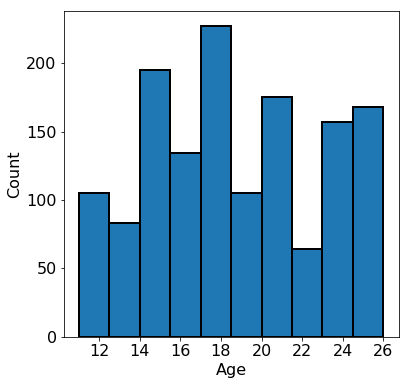

In [7]:
plot = vaccine['Age'].plot(kind='hist', figsize=(6, 6), legend=False, fontsize=16, edgecolor = 'black', linewidth=2);
plot.set_ylabel('Count', fontsize=16)
plot.set_xlabel('Age', fontsize=16)
plt.show()
plt.rcdefaults()

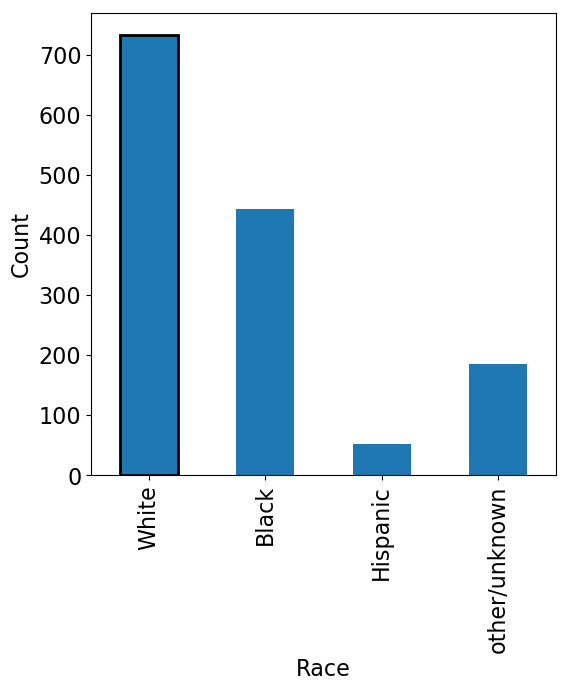

In [8]:
race = vaccine.groupby('Race')['Race'].count()
race = pd.DataFrame(race)
types = ['White', 'Black', 'Hispanic', 'other/unknown']
types = pd.DataFrame(types)
race['type'] = types
race = race.set_index('type')
race.columns = ['Count']
race.head()

plot = race['Count'].plot(kind='bar', figsize=(6, 6), fontsize=16, edgecolor = 'black', linewidth=2);
plot.set_ylabel('Count', fontsize=16)
plot.set_xlabel('Race', fontsize=16)
plt.show()
plt.rcdefaults()

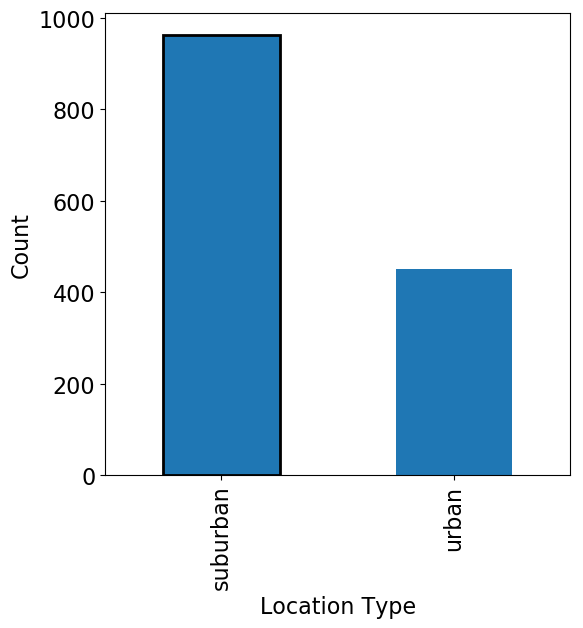

In [9]:
loc = vaccine.groupby('LocationType')['LocationType'].count()
loc = pd.DataFrame(loc)
types = ['suburban', 'urban']
types = pd.DataFrame(types)
loc['type'] = types
loc = loc.set_index('type')
loc.columns = ['Count']
loc.head()

plot = loc['Count'].plot(kind='bar', figsize=(6, 6), fontsize=16, edgecolor = 'black', linewidth=2);
plot.set_ylabel('Count', fontsize=16)
plot.set_xlabel('Location Type', fontsize=16)
plt.show()
plt.rcdefaults()

In [10]:
import warnings
warnings.filterwarnings('ignore')
vaccineC = vaccine.copy()

for i, loc in enumerate(vaccine['LocationType']):
    if loc == 0:
        vaccineC['LocationType'][i] = "suburban"
    else:
        vaccineC['LocationType'][i] = "urban"

for i, loc in enumerate(vaccine['Race']):
    if loc == 0:
        vaccineC['Race'][i] = "White"
    elif loc == 1:
        vaccineC['Race'][i] = "Black"
    elif loc == 2:
        vaccineC['Race'][i] = "Hispanic"
    else:
        vaccineC['Race'][i] = "other/unknown"

In [11]:
groups = vaccineC.groupby(['LocationType', 'Race'])['Age'].count()
groups = pd.DataFrame(groups)
groups.columns = ['Count']
groups

Count
LocationType Race                
suburban     Black            245
             Hispanic          21
             White            534
             other/unknown    163
urban        Black            198
             Hispanic          31
             White            198
             other/unknown     23

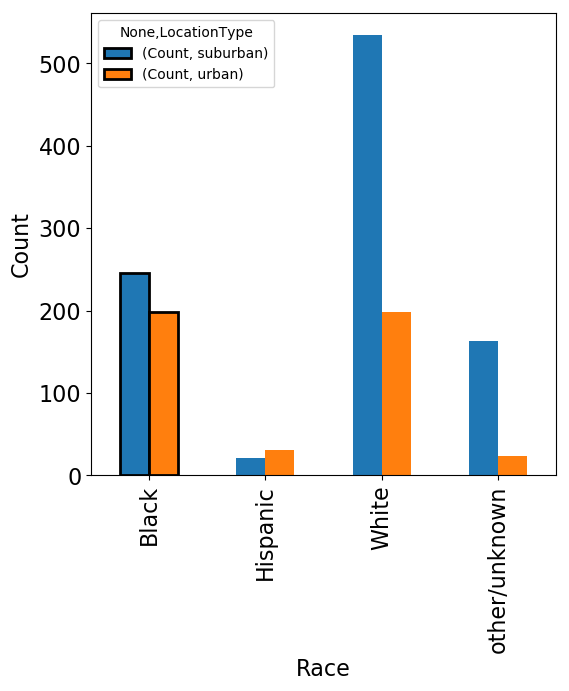

In [12]:
groups = groups.unstack("LocationType")
plot = groups.plot(kind='bar', figsize=(6, 6), fontsize=16, edgecolor = 'black', linewidth=2);
plot.set_ylabel('Count', fontsize=16)
plot.set_xlabel('Race', fontsize=16)
plt.show()
plt.rcdefaults()

In [13]:
complete = vaccine['Completed']
complete.sum() / len(complete)

0.3319179051663128

In [14]:
vaccine = vaccine.ix[:, vaccine.columns != 'Age']

In [15]:
dummy_ranks = pd.get_dummies(vaccine['Race'], prefix='Race')
dummy_ranks2 = pd.get_dummies(vaccine['LocationType'], prefix='LocationType')
vaccine = vaccine[['Completed']].join(dummy_ranks.ix[:,'Race_1':])
vaccine = vaccine[list(vaccine)].join(dummy_ranks2.ix[:,'LocationType_1':])

In [16]:
msk = np.random.rand(len(vaccine)) < 0.7
vaccineTrain = vaccine[msk]
vaccineTest = vaccine[~msk]

vaccineTrain_features = np.array(vaccineTrain.ix[:, vaccineTrain.columns != 'Completed'])
vaccineTrain_lables = np.array(vaccineTrain[['Completed']])
vaccineTrain_lables = vaccineTrain_lables.ravel()

vaccineTest_features = np.array(vaccineTest.ix[:, vaccineTest.columns != 'Completed'])
vaccineTest_lables = np.array(vaccineTest[['Completed']])
vaccineTest_lables = vaccineTest_lables.ravel()

In [17]:
L1cv = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))), random_state=333, scoring='neg_log_loss', cv=10, penalty='l1', solver='liblinear')
L1cv.fit(vaccineTrain_features, vaccineTrain_lables)
predsL1 = L1cv.predict(vaccineTest_features)

L2cv = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))),random_state=333, scoring='neg_log_loss', cv=10, penalty='l2', solver='liblinear')
L2cv.fit(vaccineTrain_features, vaccineTrain_lables)
predsL2 = L2cv.predict(vaccineTest_features)

In [18]:
# L1 regularized logistic regression confusion matrix
l1v1 = pd.DataFrame(confusion_matrix(vaccineTest_lables, predsL1))
l1v1.columns = ['Predicted 0', 'Predicted 1']
l1v1.index = ['Actual 0', 'Actual 1']
l1v1

,Predicted 0,Predicted 1
Actual 0,289,0
Actual 1,134,0


In [19]:
# L2 regularized logistic regression confusion matrix
l2v1 = pd.DataFrame(confusion_matrix(vaccineTest_lables, predsL2))
l2v1.columns = ['Predicted 0', 'Predicted 1']
l2v1.index = ['Actual 0', 'Actual 1']
l2v1

,Predicted 0,Predicted 1
Actual 0,289,0
Actual 1,134,0


Both of the models predict a label of 0 for all of the test observations! This implies that the model is no better than a random guess, as the true positive rate equals the false positive rate.


The true positive rate is given as: true positive / (true positive + false negative)

The false positive rate is given as: false positive / (false positive + true negative)

Therefore, the true positive rate for the two cases above is equal to: 0 / (0 + 128) = 0

and the false positive rate is equal to: 0 / (0 + 328) = 0

To (try to) improve the predictive power of this model we will add additional features

In [21]:
vaccine = pd.read_csv('vaccination.csv')
vaccine = vaccine[['InsuranceType', 'Location', 'MedAssist', 'Race', 'LocationType','Completed', 'PracticeType', 'AgeGroup']]
vaccine.head()

,InsuranceType,Location,MedAssist,Race,LocationType,Completed,PracticeType,AgeGroup
0,3,1,0,0,0,1,1,1
1,3,1,0,0,0,1,1,1
2,1,1,0,0,0,0,1,1
3,3,1,0,0,0,1,0,0
4,3,1,0,3,0,0,1,0


In [22]:
dummy_ranks = pd.get_dummies(vaccine['Race'], prefix='Race')
dummy_ranks2 = pd.get_dummies(vaccine['LocationType'], prefix='LocationType')
dummy_ranks3 = pd.get_dummies(vaccine['InsuranceType'], prefix='InsuranceType')
dummy_ranks4 = pd.get_dummies(vaccine['Location'], prefix='Location')
dummy_ranks5 = pd.get_dummies(vaccine['PracticeType'], prefix='PracticeType')

vaccine = vaccine[['Completed', 'MedAssist']].join(dummy_ranks.ix[:,'Race_1':])
vaccine = vaccine[list(vaccine)].join(dummy_ranks2.ix[:,'LocationType_1':])
vaccine = vaccine[list(vaccine)].join(dummy_ranks3.ix[:,'InsuranceType_1':])
vaccine = vaccine[list(vaccine)].join(dummy_ranks4.ix[:,'Location_1':])
vaccine = vaccine[list(vaccine)].join(dummy_ranks5.ix[:,'PracticeType_1':])

In [23]:
msk = np.random.rand(len(vaccine)) < 0.7
vaccineTrain = vaccine[msk]
vaccineTest = vaccine[~msk]

vaccineTrain_features = np.array(vaccineTrain.ix[:, vaccineTrain.columns != 'Completed'])
vaccineTrain_lables = np.array(vaccineTrain[['Completed']])
vaccineTrain_lables = vaccineTrain_lables.ravel()

vaccineTest_features = np.array(vaccineTest.ix[:, vaccineTest.columns != 'Completed'])
vaccineTest_lables = np.array(vaccineTest[['Completed']])
vaccineTest_lables = vaccineTest_lables.ravel()

L1cv = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))),  random_state=333, scoring='neg_log_loss', penalty='l1', solver='liblinear', max_iter=10000)
L1cv.fit(vaccineTrain_features, vaccineTrain_lables)
predsL1 = L1cv.predict(vaccineTest_features)

L2cv = LogisticRegressionCV(Cs=list(np.power(10.0, np.arange(-10, 10))), random_state=333, scoring='neg_log_loss', cv=10, penalty='l2', solver='liblinear', max_iter=10000)
L2cv = LogisticRegression()
L2cv.fit(vaccineTrain_features, vaccineTrain_lables)
predsL2 = L2cv.predict(vaccineTest_features)

In [24]:
# L1 regularized logistic regression confusion matrix
l1v2 = pd.DataFrame(confusion_matrix(vaccineTest_lables, predsL1))
l1v2.columns = ['Predicted 0', 'Predicted 1']
l1v2.index = ['Actual 0', 'Actual 1']
l1v2

,Predicted 0,Predicted 1
Actual 0,306,0
Actual 1,152,0


In [25]:

# L2 regularized logistic regression confusion matrix
l2v2 = pd.DataFrame(confusion_matrix(vaccineTest_lables, predsL2))
l2v2.columns = ['Predicted 0', 'Predicted 1']
l2v2.index = ['Actual 0', 'Actual 1']
l2v2

,Predicted 0,Predicted 1
Actual 0,289,17
Actual 1,133,19


By adding new features to the model we have improved the predictive power of the L2 regularized model.